# Test persistance

ohlcv and trades persistence with bar type and trade filtering and minsize support

```
/OHLCV/
    ├── {bar_type}/  (1s)
    │   ├── {resolution}/
    │   │   ├── {filtered_trades}-{min_trade_size}/
    │   │   │   ├── {day}/
    │   │   │   │  └── hashedname.parquet
```


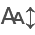

trades_df-BAC-2024-01-01T09_30_00-2024-05-14T16_00_00-CO4B7VPWUZF-100.parquet
trades_df-BAC-2024-01-11T09:30:00-2024-01-12T16:00:00.parquet
trades_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet
trades_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2024-01-11T09:30:00-2024-01-12T16:00:00.parquet
trades_df-BAC-2024-05-15T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2024-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet
ohlcv_df-BAC-2024-01-01T09_30_00-2024-05-14T16_00_00-CO4B7VPWUZF-100.parquet
ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet


In [2]:
from v2realbot.tools.loadbatch import load_batch
from v2realbot.utils.utils import zoneNY
import pandas as pd
import numpy as np
import vectorbtpro as vbt
from itables import init_notebook_mode, show
import datetime
from itertools import product
from v2realbot.config import ACCOUNT1_PAPER_API_KEY, ACCOUNT1_PAPER_SECRET_KEY, DATA_DIR
import v2realbot.utils.config_handler as cfh
init_notebook_mode(all_interactive=True)
from v2realbot.enums.enums import BarType

vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280
vbt.settings.plotting.auto_rangebreaks = True
# Set the option to display with pagination
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_rows', 10)  # Number of rows per page

# Define the market open and close times
market_open = datetime.time(9, 30)
market_close = datetime.time(16, 0)
entry_window_opens = 1
entry_window_closes = 370

forced_exit_start = 380
forced_exit_end = 390

#LOAD FROM BATCH
# res, df = load_batch(batch_id="f1ac6651", #138170bc 0fb5043a  bde6d0be f1ac6651
#                      space_resolution_evenly=False,
#                      indicators_columns=["Rsi14"],
#                      main_session_only=True,
#                      verbose = False)
# if res < 0:
#     print("Error" + str(res) + str(df))
# df = df["bars"]

# basic_data = vbt.Data.from_data(vbt.symbol_dict({"BAC": df}), tz_convert=zoneNY)
# #m1_data = basic_data[['Open', 'High', 'Low', 'Close', 'Volume']]
# basic_data = basic_data.transform(lambda df: df.between_time('09:30', '16:00'))
# #basic_data.info()

#LOAD FROM PARQUET
#list all files is dir directory with parquet extension
dir = DATA_DIR + "/notebooks/"
import os
files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
print('\n'.join(map(str, files)))
file_name = "ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet"
ohlcv_df = pd.read_parquet(dir+file_name,engine='pyarrow')

#filter ohlcv_df to certain date range (assuming datetime index)
#ohlcv_df = ohlcv_df.loc["2024-05-14 09:30":"2024-05-15 09:35"]

#add vwap column to ohlcv_df
#ohlcv_df["hlcc4"] = (ohlcv_df["close"] + ohlcv_df["high"] + ohlcv_df["low"] + ohlcv_df["close"]) / 4

basic_data = vbt.Data.from_data(vbt.symbol_dict({"BAC": ohlcv_df}), tz_convert=zoneNY)

In [15]:
#basic_data.data["BAC"].info()
#ohlcv_df group by week number of rows
# ohlcv_df['close'].groupby(pd.Grouper(freq='ME')).mean()

time
2023-01-31 00:00:00-05:00    34.365180
2023-02-28 00:00:00-05:00    35.438030
2023-03-31 00:00:00-04:00    29.484466
2023-04-30 00:00:00-04:00    29.031967
2023-05-31 00:00:00-04:00    27.928008
                               ...    
2024-01-31 00:00:00-05:00    33.221474
2024-02-29 00:00:00-05:00    33.582925
2024-03-31 00:00:00-04:00    36.142510
2024-04-30 00:00:00-04:00    36.945401
2024-05-31 00:00:00-04:00    38.438940
Freq: ME, Name: close, Length: 17, dtype: float64

In [ ]:
#trade filtering
exclude_conditions = cfh.config_handler.get_val('AGG_EXCLUDED_TRADES') #standard ['C','O','4','B','7','V','P','W','U','Z','F']
minsize = 100
exclude_conditions_str = ''.join(exclude_conditions)
exclude_conditions_str

In [ ]:
basic_data.data["BAC"].info()

Aim is to store
OHLCV grouped by symbol, day, resolution
and 
bar type
excluded_conditions
minsize
main session

In [ ]:
bartype= BarType.TIME
resolution = "1s"
trade_filter = exclude_conditions_str+"-"+str(minsize)
dir = "/OHLCV/"+bartype+"/"+resolution+"/"+trade_filter+"/"
#dir = DATA_DIR + dir
basic_data.to_parquet(partition_by="day", keep_groupby_names=False, path_or_buf=dir, mkdir_kwargs=dict(mkdir=True))  
#partition_by="day",

#naloaduje partitionvana 1s data skrz 90 dni za 2s
#day_data = vbt.ParquetData.pull("BAC", paths=dir, filters=[("group", ">", "2024-01-02"),("group", "<=", "2024-01-09")]) #, 
# day_data["2024-05-01":"2024-05-14"].get()

# day_data.data["BAC"].info()



In [ ]:
#naloaduje partitionvana 1s data skrz 90 dni za 2s
day_data = vbt.ParquetData.pull("BAC", paths=dir, filters=[("group", ">=", "2024-01-02"),("group", "<=", "2024-01-09")]) #, 
# day_data["2024-05-01":"2024-05-14"].get()

day_data.data["BAC"].info()

In [ ]:
close = basic_data.close
#group by close by day, using pandas grouper
#close.groupby(pd.Grouper(freq='ME')).mean()

#using Grouper of vectorbtpro
#close.vbt.group_by(pd.Grouper(freq='ME')).mean()

#basic_data.wrapper.get_columns()
basic_data.wrapper.get_freq()
# vbt.pdir(basic_data.wrapper)
# basic_data.wrapper
basic_data.wrapper.grouper.is_grouped()

vbt.pdir(basic_data.wrapper.grouper)



In [ ]:
grouper = basic_data.wrapper.index.vbt.get_grouper("ME")

for group, group_idx in grouper:
    print(group, group_idx)


In [ ]:
df

In [ ]:
#prevede 1milion dat (6mes 1s) na dict za 10ss
df = day_data.data["BAC"]
df_dict = df.to_dict(orient='list')

# Convert the index (which is the time) to a list of float timestamps
df_dict['time'] = [timestamp.timestamp() for timestamp in df.index]

df_dict